In [1]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:98% !important; }</style>"))

import pandas as pd
pd.set_option("display.max_columns",999)
pd.options.display.max_rows = 9999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_emails = pd.read_csv('email_data.csv',delimiter=',')
display(df_emails.head())

df_activity = pd.read_csv('activity_data.csv',delimiter=',')
display(df_activity.head())

,LogId,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,ZipCode,AddressData
0,208728980120,2019-07-31 15:13:25.817,792229022220,NaN,NaN,851332105693,nan,NaN
1,292563123584,2019-08-02 02:15:52.447,866429603262,2019-08-02 15:16:01.7533333,NaN,369293054977,nan,NaN
2,72552047640,2019-08-07 16:21:37.293,383130475294,NaN,NaN,938684493058,nan,NaN
3,1089121462891,2019-08-07 16:38:03.323,792229022220,NaN,NaN,50233193142,nan,NaN
4,828770719378,2019-08-12 11:45:43.293,479810600058,NaN,NaN,369293054977,nan,NaN


,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


In [3]:
#Zachary Loran
#August 6, 2021

#Question 1

#Number of rows in email dataset
nrow_email = len(df_emails.index)
print(f"There are {nrow_email:,} rows in the dataset 'email_data.csv'")

#Number of rows in activty dataset
nrow_activity = len(df_activity.index)
print(f"There are {nrow_activity:,} rows in the dataset 'activity_data.csv'")

#Number of total emails
total_emails = int((1 / 0.03) * nrow_email)
print(f"If the log of emails represents 3% of the emails we sent, then there was a total of {total_emails:,} emails sent")

There are 474,163 rows in the dataset 'email_data.csv'
There are 4,559,973 rows in the dataset 'activity_data.csv'
If the log of emails represents 3% of the emails we sent, then there was a total of 15,805,433 emails sent


In [4]:
#Question 2

#Import modules for converting time zones and reformatting dates
import datetime
import pytz

#Find earliest and most recent emails' time zones in UTC
earliest_email = min(df_emails["EmailSentDateTimeUtc"])
m_recent_email = max(df_emails["EmailSentDateTimeUtc"])

#Define time zones
utc = pytz.timezone("UTC")
pst = pytz.timezone("US/Pacific")

#Define current date/time format
earliest_email = datetime.datetime.strptime(earliest_email,"%Y-%m-%d %H:%M:%S.%f")
m_recent_email = datetime.datetime.strptime(m_recent_email,"%Y-%m-%d %H:%M:%S.%f")

#Convert from UTC to PST
earliest_email_utc = utc.localize(earliest_email)
earliest_email_pst = earliest_email_utc.astimezone(pst)
m_recent_email_utc = utc.localize(m_recent_email)
m_recent_email_pst = m_recent_email_utc.astimezone(pst)

#Reformat date/time into desired format
earliest_email_pst = earliest_email_pst.strftime("%m/%d/%Y %H:%M")
m_recent_email_pst = m_recent_email_pst.strftime("%m/%d/%Y %H:%M")

#Print
print(f"Earliest date of emails sent in this dataset in California time: {earliest_email_pst}")
print(f"Most recent date of emails sent in this dataset in California time: {m_recent_email_pst}")

Earliest date of emails sent in this dataset in California time: 01/03/2018 20:29
Most recent date of emails sent in this dataset in California time: 04/19/2021 06:45


In [5]:
#Question 3

#Import module for converting string to dictionary
import ast

#Extract zip codes from dataset
zipcodes = list()
for row in df_emails[df_emails["AddressData"].notnull()]["AddressData"]:
    zips = ast.literal_eval(row)["ZipCode"][-5:]
    if zips != "NULL":
        zipcodes.append(zips)

#Count number of each zip code
zip_df = pd.DataFrame(zipcodes, columns = {'Count': '0'})
count_df = pd.DataFrame(zip_df['Count'].value_counts())

#Print
print("The 10 zip codes that receive the most emails:")
count_df[0:10]

The 10 zip codes that receive the most emails:


,Count
63301,312
33801,310
34210,299
38301,295
67460,285
95971,277
42301,266
36104,254
40769,234
85225,229


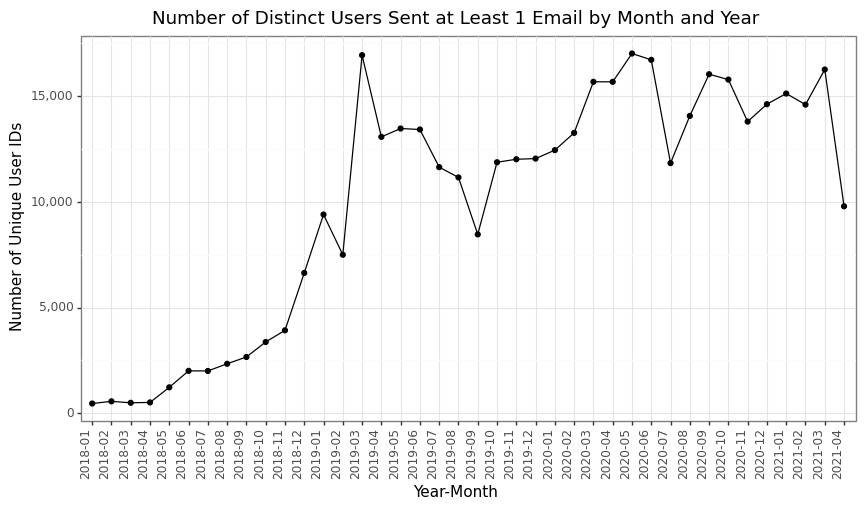

<ggplot: (8771188443224)>

In [6]:
#Question 4

#Run this if module plotnine not installed:
#conda install -c conda-forge plotnine
import plotnine
from plotnine import *



##### First Plot #####

#Create a list of formatted PST years and months for each email sent
year_month = []
for email in df_emails["EmailSentDateTimeUtc"]:
    email = datetime.datetime.strptime(email,"%Y-%m-%d %H:%M:%S.%f")
    email = utc.localize(email)
    email = email.astimezone(pst)
    year_month.append(email.strftime("%Y-%m"))

#Duplicate email dataset and add year-month column
df_emails_new = df_emails
df_emails_new["YearMonth"] = year_month

#Find the number of unique UserId's for each year-month combo, and create a DataFrame out of this
df_emails_unique = df_emails_new.groupby(["YearMonth"])["UserId"].agg(["unique"])
df_emails_unique = df_emails_unique["unique"].apply(len)
df_emails_unique = pd.DataFrame(dict(df_emails_unique).items(), columns = ("Date", "UniqueUserIDs"))

#Configure plot view options
plotnine.options.figure_size = (10, 5)

#Plot
(ggplot(df_emails_unique, aes(x = "Date", y = "UniqueUserIDs", group = 1)) + geom_point() + geom_line() +
    labs(x = "Year-Month", y = "Number of Unique User IDs", title = "Number of Distinct Users Sent at Least 1 Email by Month and Year") +
    theme_bw() + theme(axis_text_x = element_text(rotation = 90, hjust = 1)) + 
    scale_y_continuous(breaks = range(0, 20000, 5000), labels = ["0", "5,000", "10,000", "15,000"]))

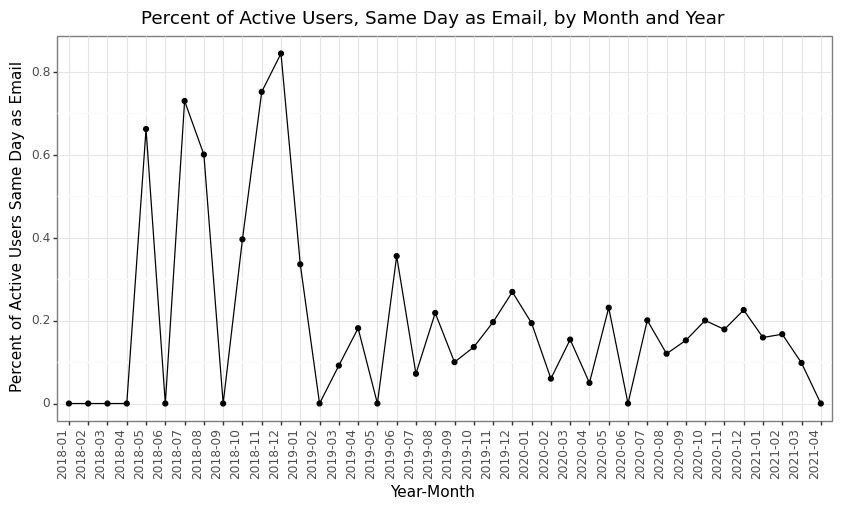

<ggplot: (8771189093922)>

In [7]:
#Question 4
##### Second Plot #####

#Import NumPy for RNG
import numpy as np

#I was having some runtime issues on this second plot (it was taking too long to run)
#So, I decided to subset the dataframes into a smaller chunk of rows, so it would run in a more timely manner

#Duplicate dataframes
df_emails_n = df_emails
df_activity_n = df_activity
df_emails_new_n = df_emails_new

#Subset duplictaed dataframes randomly
rand = np.random.randint(0, len(df_emails), 50000)
df_emails_n = df_emails_n.iloc[rand, 0:9]
df_activity_n = df_activity_n.iloc[rand, 0:4]
df_emails_new_n = df_emails_new_n.iloc[rand, 0:10]

#Extract formatted PST days from email dataset
days_email = []
for email in df_emails_n["EmailSentDateTimeUtc"]:
    email = datetime.datetime.strptime(email,"%Y-%m-%d %H:%M:%S.%f")
    email = utc.localize(email)
    email = email.astimezone(pst)
    days_email.append(email.strftime("%Y-%m-%d"))

#Extract days from acitivty dataset
days_activity = []
for activity in df_activity_n["DateOfActivityPST"]:
    days_activity.append(activity)

#Extract user ID's from email dataset
users_email = []
for user in df_emails_n["UserId"]:
    users_email.append(user)
    
#Extract user ID's from activty dataset
users_activity = []
for user in df_activity_n["UserId"]:
    users_activity.append(user)

#Merge days and ID's into one column in email dataset
days_users_email = []
for i in range(0, len(df_emails_n)):
    days_users_email.append(str(days_email[i]) + " " + str(users_email[i]))

#Merge days and ID's into one column in activity dataset
days_users_activity = []
for i in range(0, len(df_activity_n)):
    days_users_activity.append(str(days_activity[i]) + " " + str(users_activity[i]))

#Keep tack of whether for a given day and user, that user logged in or not that day
tracker = []
for i in range(0, len(df_emails_n)):
    tracker.append(days_users_email[i] in days_users_activity)
df_emails_new_n["Tracker"] = tracker

#Sum the number of times a user logged in same day as recieving email by month, and make into dataframe
df_emails_percent_n = df_emails_new_n.groupby(["YearMonth"])["Tracker"].sum()
sums = list(df_emails_percent_n)
df_emails_percent_n = pd.DataFrame(dict(df_emails_percent_n).items(), columns = ("Date", "Sum"))

#Sum the number of emails total by month in our subsetted dataset, and add this 'count' into dataframe
df_emails_percent_n2 = df_emails_new_n.groupby(["YearMonth"])["Tracker"].count()
count = list(df_emails_percent_n2)
df_emails_percent_n["Count"] = count

#Calculate percent of emails by dividing 'sum' by 'count', and add 'percent' to dataframe
percent = []
for i in range(0, len(sums)):
    percent.append(sums[i]/count[i]*100)
df_emails_percent_n["Percent"] = percent

#Plot
(ggplot(df_emails_percent_n, aes(x = "Date", y = "Percent", group = 1)) + geom_point() + geom_line() +
    labs(x = "Year-Month", y = "Percent of Active Users Same Day as Email", title = "Percent of Active Users, Same Day as Email, by Month and Year") +
    theme_bw() + theme(axis_text_x = element_text(rotation = 90, hjust = 1)))

In [8]:
#Question 5

#Duplicate emails dataframe and filter to only emails that were clicked
df_emails_filter = df_emails.copy()
df_emails_filter = df_emails_filter[df_emails_filter["EmailClickedDateTimeUtc"].notnull()]

#Convert 'click-time' to PST and reformat date, and extract this data
days_click = []
for click in df_emails_filter["EmailClickedDateTimeUtc"]:
    click = datetime.datetime.strptime(click[0:10],"%Y-%m-%d")
    click = utc.localize(click)
    click = click.astimezone(pst)
    days_click.append(click.strftime("%Y-%m-%d"))
days_click

#Extract UserId and CampaignId data from email dataset and zip this into a list with 'click-date'
user_click = list(df_emails_filter["UserId"])
campaign_click = list(df_emails_filter["EmailCampaignId"])
zip_click = list(zip(days_click, user_click, campaign_click))

#Extract UserId and Activity date from activity dataset, and zip both into a list
days_activity = list(df_activity["DateOfActivityPST"])
user_activity = list(df_activity["UserId"])
zip_activity = list(zip(days_activity, user_activity))

#If a pair of UserId and Click-dates do not have a match with a UserId and Activity date pair, then record the CampaignId as having a broken link
#Note: this line may take a long time to run
broken_campaigns = [click[2] for click in zip_click if click[0:2] not in zip_activity]            

#Count the number of broken links per campaign, and convert to Dataframe
broken_camp = pd.DataFrame(broken_campaigns, columns = ["BrokenCampaigns"])
broken_camp = broken_camp.groupby(["BrokenCampaigns"]).size()
broken_camp = pd.DataFrame(dict(broken_camp).items(), columns = ("CampaignID", "NumOfBrokenLinks"))

#Filter dataframe to just campaigns with more than 100 broken links, and re-order dataframe
broken_camp = broken_camp[broken_camp["NumOfBrokenLinks"] > 100]
broken_camp = broken_camp.sort_values("NumOfBrokenLinks", ascending = False)

#Calculate upper bound for number of users affected by broken links for each campaign, and add to dataframe
#Based on fact that email dataframe is only 3% of all emails sent
broken_camp["UpperBound"] = [ int((1/0.03)*i) for i in list(broken_camp["NumOfBrokenLinks"])]

#Calulate total number of users and total number of broken links
total_users = len(df_emails['UserId'].unique())
total_broken = int(broken_camp["NumOfBrokenLinks"].sum(axis = 0))

#Import random module for RNG
import random

#Estimate the probability that a user has recieved multiple emails with broken links
#Using a Monte Carlo simulation based on the parameters defined above
rand_list = [random.randint(0, total_users) for i in range(total_broken)]
rand_list = pd.DataFrame(rand_list, columns = ["Rand"])
rand_list = rand_list.groupby(["Rand"]).size()
rand_list = pd.DataFrame(dict(rand_list).items(), columns = ("Rand", "Count"))
rand_list = rand_list[rand_list["Count"] > 1]
probability = (len(rand_list)/total_users) * 100

#Print
print("There are approximately " + str(len(broken_camp)) + " email campaigns with broken links with a total of " + \
      f"{total_broken:,}" + " broken links.")
print("There is a " + str(round(probability, 3)) + "% probability that a user who gets email from FieldLevel has experienced " + \
      "a broken link multiple times.\n")
print("   In conclusion, it seems like a significant number of email links across multiple campaigns are broken.\n" + \
      "Specifically, this analysis yeilded 20 email campaigns with a significant (>100) number of broken links.\n" + \
      "Given the number of total users and the number of broken links sent out, there is approximately a 0.514% probability\n" + \
      "of any given FieldLevel user recieving a broken link multiple times. This probability was calculated emprirically,\n" + \
      "through generating random numbers, and thus serves as a rough estimate of the rate that users recieve multiple\n" + \
      "emails with broken links. While 0.514% is relatively small, keep in mind the rate of users recieving one or\n" + \
      "more broken links is much higher. Finally, the table below shows which 20 campaigns (by CampaignID) had a large\n" + \
      "number of broken links, how many broken links they had, and an upper bound estimate of the maximum number of users\n" + \
      "the campaign had the potential to affect. This upper bound estimate was made under the assumption that this dataset\n" + \
      "is only 3% of the total emails sent, which explains why the upper bounds are relatively large. Keep in mind that\n" + \
      "these are upper bounds, and the numbers of users actually recieving broken links are likely much smaller. Overall,\n" + \
      "the team should investigate why some links are broken (or if there are other issues explaining why 'clicks' are\n" + \
      "not corresponding to user activity), as the rate of broken links is high.")
display(broken_camp)

There are approximately 20 email campaigns with broken links with a total of 11,037 broken links.
There is a 0.507% probability that a user who gets email from FieldLevel has experienced a broken link multiple times.

   In conclusion, it seems like a significant number of email links across multiple campaigns are broken.
Specifically, this analysis yeilded 20 email campaigns with a significant (>100) number of broken links.
Given the number of total users and the number of broken links sent out, there is approximately a 0.514% probability
of any given FieldLevel user recieving a broken link multiple times. This probability was calculated emprirically,
through generating random numbers, and thus serves as a rough estimate of the rate that users recieve multiple
emails with broken links. While 0.514% is relatively small, keep in mind the rate of users recieving one or
more broken links is much higher. Finally, the table below shows which 20 campaigns (by CampaignID) had a large
number o

,CampaignID,NumOfBrokenLinks,UpperBound
33,653571247008,1830,61000
20,479810600058,1727,57566
2,82833411612,1263,42100
32,653559880232,1080,36000
31,642285457495,1044,34800
7,192312213095,693,23100
4,146804146660,549,18300
14,319208351769,381,12700
21,480484577588,374,12466
19,461658501013,340,11333


In [9]:
#Question 6

#Create dataframe
campaigns = df_emails.groupby(["EmailCampaignId"])["LogId"].count()
campaigns = pd.DataFrame(dict(campaigns).items(), columns = ("CampaignID", "NumOfEmails"))

#Count number of emails sent and clicked on per campaign, as well as earlist and latest date of each campaign
num_campaign = list(df_emails.groupby(["EmailCampaignId"])["LogId"].count())
click_campaign = list(df_emails.groupby(["EmailCampaignId"])["EmailClickedDateTimeUtc"].count())
min_campaign = list(df_emails.groupby(["EmailCampaignId"])["YearMonth"].min())
max_campaign = list(df_emails.groupby(["EmailCampaignId"])["YearMonth"].max())

#Add above data to new dataframe
campaigns["EmailsClicked"] = click_campaign
campaigns["EarliestMonth"] = min_campaign
campaigns["LatestMonth"] = max_campaign

#Calculate percent of emails clicked on per campaign by dividing emails clicked on by total emails sent
percentage = []
for i in range(0, len(campaigns)):
    percentage.append(click_campaign[i]/num_campaign[i]*100)
campaigns["Percent"] = percentage

#Define criteria for the team's product manager to consider no longer sending a campaign
criteria1 = list(campaigns["Percent"] < 5)
criteria2 = list(campaigns["NumOfEmails"] > 100)
criteria = []
for i in range(0, len(campaigns)):
    criteria.append(bool(criteria1[i] and criteria2[i]))
campaigns["RemovalCriteria"] = criteria

#Print
print("Below is a list of campaigns that meet the following criteria for consideration of ending the campaign:\n" + \
      "1) Less than 5% of the emails were clicked on, and \n2) The campaign sent out at least 100 emails.")
print("\nUpon insepction, it seems that campaigns that meet this criteria are somewhat evenly distributed across time. However, perhaps " + \
      "some of the \ncampaigns that were started in earlier years and continued through 2021 have been performing disproportionately poorly, " + \
      "and this should be\nfurther investigated.")
campaigns[campaigns["RemovalCriteria"] == True]

Below is a list of campaigns that meet the following criteria for consideration of ending the campaign:
1) Less than 5% of the emails were clicked on, and 
2) The campaign sent out at least 100 emails.

Upon insepction, it seems that campaigns that meet this criteria are somewhat evenly distributed across time. However, perhaps some of the 
campaigns that were started in earlier years and continued through 2021 have been performing disproportionately poorly, and this should be
further investigated.


,CampaignID,NumOfEmails,EmailsClicked,EarliestMonth,LatestMonth,Percent,RemovalCriteria
3,82833411612,121542,1870,2019-01,2021-04,1.539,True
5,122198019089,304,2,2019-08,2021-04,0.658,True
8,184779603016,1931,42,2020-06,2020-06,2.175,True
9,192312213095,53467,1232,2018-11,2021-04,2.304,True
20,383130475294,247,0,2019-07,2021-04,0.000,True
24,420788124781,2232,86,2020-05,2021-03,3.853,True
29,479810600058,80269,2248,2018-11,2021-04,2.801,True
30,480484577588,22721,541,2019-02,2021-04,2.381,True
38,567459485975,7991,330,2020-04,2021-04,4.130,True
40,586212006108,162,6,2018-04,2021-03,3.704,True


<ipython-input-10-c2e9fa9f64d2>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-10-c2e9fa9f64d2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


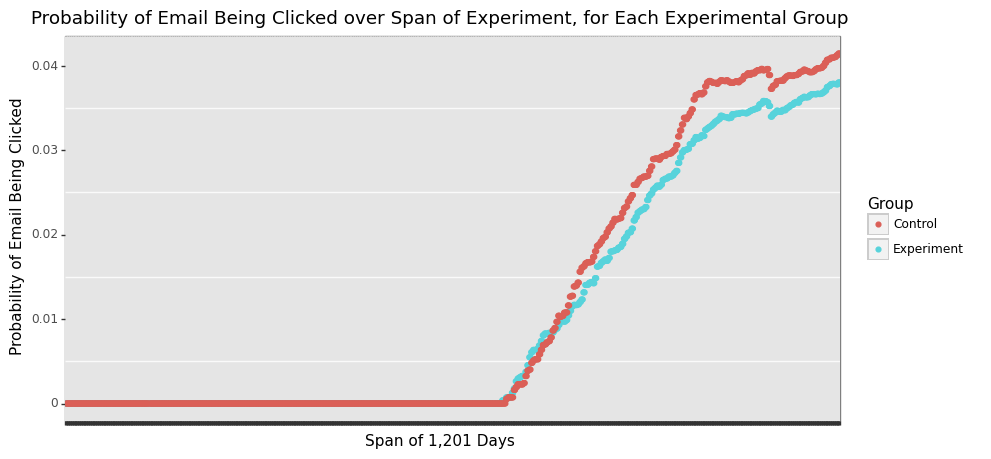

<ggplot: (8771139982800)>

In [10]:
#Question 7

#Duplicate dataframe
df_emails_experiment = df_emails

#Assign experiment and control groups
groups = []
for row in df_emails_experiment["UserId"]:
    if row >= 20000000 and row <= 498689408027:
        groups.append("Control")
    elif row > 498689408027 and row <= 1000000000000:
        groups.append("Experiment")
    else:
        groups.append("NaN")
df_emails_experiment["Group"] = groups 

#Convert dates to PST and reformat, and add to DataFrame
days_email = []
for email in df_emails_experiment["EmailSentDateTimeUtc"]:
    email = datetime.datetime.strptime(email,"%Y-%m-%d %H:%M:%S.%f")
    email = utc.localize(email)
    email = email.astimezone(pst)
    days_email.append(email.strftime("%Y-%m-%d"))
df_emails_experiment["Day"] = days_email

#Group by dataframe by day and experimental group, and count the number of email clicks - put into a new dataframe
click_experiment = df_emails_experiment.groupby(["Day", "Group"])["EmailClickedDateTimeUtc"].count()
clicks = list(df_emails_experiment.groupby(["Day", "Group"])["EmailClickedDateTimeUtc"].count())
click_experiment = pd.DataFrame(list(dict(click_experiment).items()), columns = ("DayGroup", "NumOfClicks"))

#Add the number of emails sent by day and group to the dataframe
sents = list(df_emails_experiment.groupby(["Day", "Group"])["LogId"].count())
click_experiment["NumOfSent"] = sents

#Split dataset into experiment and control groups for next step, and clean dataset columns
day_split = []
group_split = []
for i in click_experiment["DayGroup"]:
    day_split.append(i[0])
    group_split.append(i[1])
click_experiment["Day"] = day_split
click_experiment["Group"] = group_split

#Find the cumulative probability of an email being clicked for the experiment group
click_experiment_exp = click_experiment[click_experiment["Group"] == "Experiment"]
probability_exp = []
for i in range(0, len(click_experiment_exp)):
    probability_exp.append(sum(click_experiment_exp.loc[0:i, "NumOfClicks"])/(sum(click_experiment_exp.loc[0:i, "NumOfSent"])+1))
click_experiment_exp["Probability"] = probability_exp

#Find the cumulative probability of an email being clicked for the control group
click_experiment_con = click_experiment[click_experiment["Group"] == "Control"]
probability_con = []
for i in range(0, len(click_experiment_con)):
    probability_con.append(sum(click_experiment_con.loc[0:i, "NumOfClicks"])/(sum(click_experiment_con.loc[0:i, "NumOfSent"])+1))
click_experiment_con["Probability"] = probability_con

#Concat. experiment and control datasets back into one dataset, and clean columns
click_experiment = pd.concat([click_experiment_exp, click_experiment_con])
click_experiment = click_experiment[["Day", "Group", "Probability"]]

#Plot
(ggplot(click_experiment, aes(x = "Day", y = "Probability", color = "Group", group = 1)) + geom_point() + \
     scale_x_discrete(labels = [""]) + \
     labs(x = "Span of 1,201 Days", y = "Probability of Email Being Clicked", \
          title = "Probability of Email Being Clicked over Span of Experiment, for Each Experimental Group") + theme_bw())

Overall, this is an 'okay-at-best' experimental design. The process of splitting users into two groups, one experimental (to try out the new email design) and one control (to keep the old design constant) is a good idea. Hence, the general structure of the experiment is good - one variable is changed in one of the groups, and this can be used to compare the outcomes (probability of clicks) to the unchanged other group. The main problem arises with how the groups are selected. Because User ID's are assigned in chronological order, assigning users into groups by User ID make the process non-random. One of the core pillars of good experimental design is random assignment into experiment and control groups, and this process fails the randomness paradigm. Specifically, this experimental design introduces in the confounding factor of how long a user has been signed up with FieldLevel, and this could influence the results and blur the distinction we are actually interested in: the difference between the old and new email designs. Therefore, while the general skeleton of the design is solid, the random assignment issue poses a large problem that ought to be resolved.

Six months from most recent activity: 2020-10-19
Total number of users in activity dataset: 90,051
Number of unengaged users: 38,346


<ipython-input-11-94c564f1d2e2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of users who did not recieve an email in last six months: 37,342
Number of engaged users: 15,208

   Of 37,342 users who did not recieve an email in the last 6 months, 15,208 or 40.73% were engaged
even without emails prompting them. This means that 59.27% were unengaged without emails. When
we compare this to the overall percentage of unengaged users 42.58%, this  overall percentage
is significantly lower (~17%), so there is statistical evidence that sending emails has the effect
of reducing the proportion of unengaged users. Therefore, while the product managers concern is
valid, emails seem to be an effective way to reduce dis-engagement amongst users.

   Further, this boxplot shows the difference in users' total activity count across engaged and
unengaged users. Not only is the mean significantly higher, but an exmaination of the variance/spread
of the data reveals that even the 3rd quartile of activity count for unengaged users is less than
the mean for engaged users. This

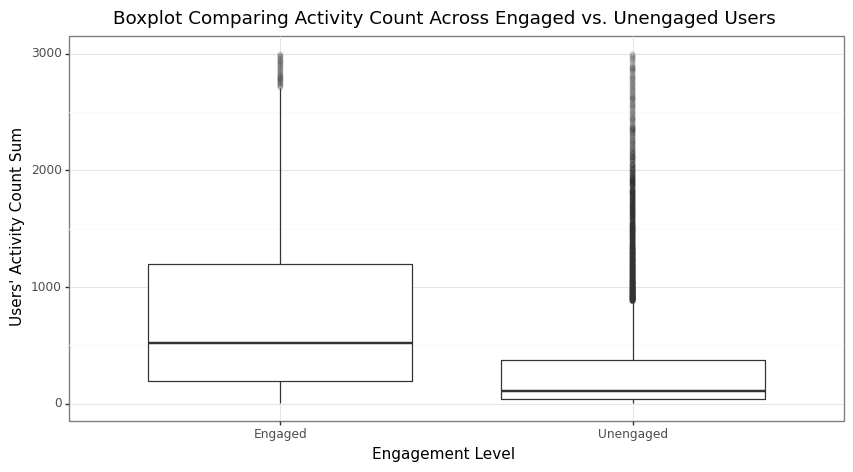

<ggplot: (8771189189145)>

In [11]:
#Question 8

#Duplicate activity dataframe
df_activity_copy = df_activity.copy()

#Find the most recent 6 month period through which to measure engagement
m_recent_activity = max(df_activity_copy["DateOfActivityPST"])
m_recent_activity = datetime.datetime.strptime(m_recent_activity, "%Y-%m-%d")
six_months = m_recent_activity - pd.DateOffset(months = 6)
six_months = six_months.strftime("%Y-%m-%d")
print(f"Six months from most recent activity: {six_months}")

#Subset the dataframe to just activity dates within 6 most recent months
df_activity_copy = df_activity_copy[df_activity_copy["DateOfActivityPST"] > six_months]

#Order dataframe by date
df_activity_copy["DateOfActivityPST"] = [datetime.datetime.strptime(row, "%Y-%m-%d") for row in df_activity_copy["DateOfActivityPST"]]
df_activity_copy = df_activity_copy.sort_values("DateOfActivityPST")
df_activity_copy["DateOfActivityPST"] = [datetime.datetime.strftime(row, "%Y-%m-%d") for row in df_activity_copy["DateOfActivityPST"]]

#Determine which users were not active in last 6 months and calculate total users 
en_users = list(df_activity_copy["UserId"].unique())
unen_users = []
uniques = list(df_activity["UserId"].unique())
for i in range(0, len(uniques)):
    if uniques[i] not in en_users:
        unen_users.append(uniques[i])
print(f"Total number of users in activity dataset: {len(df_activity['UserId'].unique()):,}")
print(f"Number of unengaged users: {len(unen_users):,}")

#Subset the email dataframe to just email dates within 6 most recent months
df_emails_experiment = df_emails_experiment[df_emails_experiment["Day"] > six_months]

#Order dataframe by date
df_emails_experiment["Day"] = [datetime.datetime.strptime(row, "%Y-%m-%d") for row in df_emails_experiment["Day"]]
df_emails_experiment = df_emails_experiment.sort_values("Day")
df_emails_experiment["Day"] = [datetime.datetime.strftime(row, "%Y-%m-%d") for row in df_emails_experiment["Day"]]

#Determine which users did not recieve emails in the last 6 months
em_users = list(df_emails_experiment["UserId"].unique())
nonem_users = []
uniques = list(df_activity["UserId"].unique())
for i in range(0, len(uniques)):
    if uniques[i] not in em_users:
        nonem_users.append(uniques[i])
print(f"Number of users who did not recieve an email in last six months: {len(nonem_users):,}")

#Determine which users were 'engaged' - did not receive emails but still had activity in last 6 months
nonem_en = []
for i in range(0, len(nonem_users)):
    if nonem_users[i] in en_users:
        nonem_en.append(nonem_users[i])
print(f"Number of engaged users: {len(nonem_en):,}")

#Print
print(f"\n   Of {len(nonem_users):,} users who did not recieve an email in the last 6 months, {len(nonem_en):,} or " + \
      f"{round(len(nonem_en)/len(nonem_users)*100, 2)}% were engaged\neven without emails prompting them. This means that " + \
      f"{round(100 - (len(nonem_en)/len(nonem_users)*100), 2)}% were unengaged without emails. When\nwe compare this to the " + \
      f"overall percentage of unengaged users {round(len(unen_users) / len(df_activity['UserId'].unique())*100, 2)}%, this " + \
      f" overall percentage\nis significantly lower (~17%), so there is statistical evidence that sending emails has the effect\nof " + \
      f"reducing the proportion of unengaged users. Therefore, while the product managers concern is\nvalid, emails seem to be an effective " + \
      f"way to reduce dis-engagement amongst users.")

#Calulate the sum of activity counts for each user in the 'engaged' and 'unengaged' groups
engage_users = nonem_en + unen_users
engage_count = []
engage_label = []
for user in nonem_en:
    engage_count.append(sum(df_activity[df_activity["UserId"] == user]["ActivityCount"]))
    engage_label.append("Engaged")
for user in unen_users:
    engage_count.append(sum(df_activity[df_activity["UserId"] == user]["ActivityCount"]))
    engage_label.append("Unengaged")

#Create dataframe based on above activity count sums, to be used in boxplot below
actCount_df = pd.DataFrame(list(zip(engage_users, engage_count, engage_label)),
                           columns = ["UserId", "SumActivityCount", "EngagementGroup"])

#Print
print(f"\n   Further, this boxplot shows the difference in users' total activity count across engaged and\nunengaged users. " + \
      f"Not only is the mean significantly higher, but an exmaination of the variance/spread\nof the data reveals that " + \
      f"even the 3rd quartile of activity count for unengaged users is less than\nthe mean for engaged users. This provides " + \
      f"further evidence that emails are an effective way to\nincrease user engagement.")

#Plot
(ggplot(actCount_df[actCount_df["SumActivityCount"] < 3000], aes(x = "EngagementGroup", y = "SumActivityCount")) + \
    geom_boxplot(outlier_alpha = 0.01) + theme_bw() + ylim(0,3000) + \
    labs(x = "Engagement Level", y = "Users' Activity Count Sum", title = "Boxplot Comparing Activity Count Across Engaged vs. Unengaged Users"))